# 🚀 Next Steps: Advanced Analysis & Machine Learning

Now that we have successfully processed proteins, ligands, and pockets into standardized 3D grids, we can proceed with advanced analysis and machine learning applications.

## 1) Imports

In [1]:
!pip install rdkit

!pip install tqdm

!pip install scikit-learn

!pip install ovito


In [2]:
# # Fix OpenMP library conflicts and other potential issues
import os
import sys
import gc

# Handle OpenMP library conflicts
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# # Limit threading to reduce memory contention
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"
# os.environ["OMP_NUM_THREADS"] = "1"

# # Force PyTorch to use CPU instead of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# # Enable aggressive garbage collection
# gc.enable()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Import F for functional API like F.mse_loss
from torch.utils.data import DataLoader # Ensure DataLoader is imported here if not already

In [4]:
import numpy as np
import torch
from itertools import product
from typing import Sequence, Tuple, Optional
import time
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
import json
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen
import os
import glob
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Union
import logging
from dataclasses import dataclass
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
import pickle
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# ovito imports
import numpy as np
from ovito.io import export_file
from ovito.pipeline import StaticSource, Pipeline
from ovito.data import Particles, ParticleType
from ovito.modifiers import SelectTypeModifier, ColorCodingModifier

## 2) load it processed data from files prepped in step4

In [6]:
# Load and validate all processed data
print(" Loading all processed molecular data...")

# Load protein data
if os.path.exists("processed_protein_data/protein_grids.npy"):
    protein_grids = np.load("processed_protein_data/protein_grids.npy")
    with open("processed_protein_data/metadata.json", 'r') as f:
        protein_metadata = json.load(f)
    print(f" Loaded protein data: {protein_grids.shape}")
else:
    print(f" ERROR")

# Load ligand data
if os.path.exists("processed_ligand_data/ligand_grids.npy"):
    ligand_grids = np.load("processed_ligand_data/ligand_grids.npy")
    with open("processed_ligand_data/ligand_metadata.json", 'r') as f:
        ligand_metadata = json.load(f)
    print(f" Loaded ligand data: {ligand_grids.shape}")
else:
    ligand_grids = all_ligand_grids
    ligand_metadata = all_ligand_metadata
    print(f" Using in-memory ligand data: {len(ligand_grids)} ligands")

# Load pocket data
if os.path.exists("processed_pocket_data/pocket_grids.npy"):
    pocket_grids = np.load("processed_pocket_data/pocket_grids.npy")
    with open("processed_pocket_data/pocket_metadata.json", 'r') as f:
        pocket_metadata = json.load(f)
    print(f" Loaded pocket data: {pocket_grids.shape}")
else:
    pocket_grids = all_pocket_grids
    pocket_metadata = all_pocket_metadata
    print(f" Using in-memory pocket data: {len(pocket_grids)} pockets")

print(f"\n Complete Dataset Summary:")
print(f"    Proteins: {len(protein_grids)} samples")
print(f"    Ligands: {len(ligand_grids)} samples")
print(f"    Pockets: {len(pocket_grids)} samples")
print(f"    Grid resolution: {protein_grids.shape[1:] if len(protein_grids) > 0 else 'N/A'}")
print(f"    Total memory: {(protein_grids.nbytes + ligand_grids.nbytes + pocket_grids.nbytes) / 1024**3:.2f} GB")

 Loading all processed molecular data...
 Loaded protein data: (188, 19, 64, 64, 64)
 Loaded ligand data: (229, 19, 64, 64, 64)
 Loaded pocket data: (210, 19, 64, 64, 64)

 Complete Dataset Summary:
    Proteins: 188 samples
    Ligands: 229 samples
    Pockets: 210 samples
    Grid resolution: (19, 64, 64, 64)
    Total memory: 11.63 GB


## 3) create matching datasets

In [7]:
# Create matched protein-ligand-pocket datasets (memory-efficient)
print(" Creating matched molecular complex datasets...")

# Extract successful entries with IDs
def extract_successful_with_ids(metadata):
    """Extract successful entries with their molecular IDs"""
    successful = []
    for entry in metadata:
        if entry.get('success', False):
            # Try different ID field names
            mol_id = entry.get('protein_id') or entry.get('ligand_id') or entry.get('pocket_id')
            if mol_id:
                successful.append((mol_id, entry))
    return successful

# Get successful entries for each component
protein_success = extract_successful_with_ids(protein_metadata)
ligand_success = extract_successful_with_ids(ligand_metadata)
pocket_success = extract_successful_with_ids(pocket_metadata)

print(f"Successful entries:")
print(f"    Proteins: {len(protein_success)}")
print(f"    Ligands: {len(ligand_success)}")
print(f"    Pockets: {len(pocket_success)}")

# Create ID mappings
protein_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(protein_success)}
ligand_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(ligand_success)}
pocket_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(pocket_success)}

# Find common molecular complexes (where we have all three components)
common_ids = set(protein_ids.keys()) & set(ligand_ids.keys()) & set(pocket_ids.keys())
print(f"\n Found {len(common_ids)} complete molecular complexes with all three components!")

# For memory efficiency, work with a much smaller subset
max_samples = min(20, len(common_ids))  # Reduce to 10 samples to avoid memory issues
common_ids_sample = sorted(list(common_ids))[:max_samples]

print(f" Using {len(common_ids_sample)} samples for analysis (memory-efficient)")

# Create matched datasets for the sample
matched_protein_indices = [protein_ids[mol_id] for mol_id in common_ids_sample]
matched_ligand_indices = [ligand_ids[mol_id] for mol_id in common_ids_sample]
matched_pocket_indices = [pocket_ids[mol_id] for mol_id in common_ids_sample]

# Calculate memory requirement before allocation
single_grid_mb = (19 * 64 * 64 * 64 * 4) / (1024 * 1024)  # 4 bytes per float32
total_memory_mb = single_grid_mb * max_samples * 3  # 3 components
print(f" Estimated memory requirement: {total_memory_mb:.1f} MB")

# Extract matched grids with memory-efficient approach
try:
    # Process in smaller batches to avoid memory allocation peaks
    batch_size = 5
    matched_proteins_list = []
    matched_ligands_list = []
    matched_pockets_list = []
    
    for i in range(0, len(matched_protein_indices), batch_size):
        batch_end = min(i + batch_size, len(matched_protein_indices))
        batch_protein_idx = matched_protein_indices[i:batch_end]
        batch_ligand_idx = matched_ligand_indices[i:batch_end]
        batch_pocket_idx = matched_pocket_indices[i:batch_end]
        
        # Extract batch
        batch_proteins = protein_grids[batch_protein_idx]
        batch_ligands = ligand_grids[batch_ligand_idx]
        batch_pockets = pocket_grids[batch_pocket_idx]
        
        matched_proteins_list.append(batch_proteins)
        matched_ligands_list.append(batch_ligands)
        matched_pockets_list.append(batch_pockets)
    
    # Concatenate batches
    matched_proteins = np.concatenate(matched_proteins_list, axis=0)
    matched_ligands = np.concatenate(matched_ligands_list, axis=0)
    matched_pockets = np.concatenate(matched_pockets_list, axis=0)
    
except MemoryError as e:
    print(f"⚠️  Memory error encountered: {e}")
    print("   Reducing sample size further...")
    
    # Further reduce sample size
    max_samples = min(5, len(common_ids))
    common_ids_sample = sorted(list(common_ids))[:max_samples]
    matched_protein_indices = [protein_ids[mol_id] for mol_id in common_ids_sample]
    matched_ligand_indices = [ligand_ids[mol_id] for mol_id in common_ids_sample]
    matched_pocket_indices = [pocket_ids[mol_id] for mol_id in common_ids_sample]
    
    print(f"   Trying with only {max_samples} samples...")
    matched_proteins = protein_grids[matched_protein_indices]
    matched_ligands = ligand_grids[matched_ligand_indices]
    matched_pockets = pocket_grids[matched_pocket_indices]

print(f"\n✅ Matched Dataset Created Successfully!")
print(f"    Proteins: {matched_proteins.shape}")
print(f"    Ligands: {matched_ligands.shape}")
print(f"    Pockets: {matched_pockets.shape}")
print(f"    Memory usage: {(matched_proteins.nbytes + matched_ligands.nbytes + matched_pockets.nbytes) / 1024**3:.2f} GB")

# Store the common IDs for reference
common_ids_list = common_ids_sample
print(f"    Complex IDs: {common_ids_list[:5]}{'...' if len(common_ids_list) > 5 else ''}")

# Clean up large arrays to free memory
print(f"\n🧹 Memory cleanup...")
print(f"   Before cleanup: ~{(protein_grids.nbytes + ligand_grids.nbytes + pocket_grids.nbytes) / 1024**3:.2f} GB")

# Optional: clear large arrays if memory is tight
# del protein_grids, ligand_grids, pocket_grids
print(f"   Large arrays kept in memory for further analysis")
print(f"   For memory-constrained systems, consider using the memory-efficient functions above")

 Creating matched molecular complex datasets...
Successful entries:
    Proteins: 188
    Ligands: 229
    Pockets: 210

 Found 188 complete molecular complexes with all three components!
 Using 20 samples for analysis (memory-efficient)
 Estimated memory requirement: 1140.0 MB

✅ Matched Dataset Created Successfully!
    Proteins: (20, 19, 64, 64, 64)
    Ligands: (20, 19, 64, 64, 64)
    Pockets: (20, 19, 64, 64, 64)
    Memory usage: 1.11 GB
    Complex IDs: ['1a30', '1bcu', '1bzc', '1c5z', '1eby']...

🧹 Memory cleanup...
   Before cleanup: ~11.63 GB
   Large arrays kept in memory for further analysis
   For memory-constrained systems, consider using the memory-efficient functions above


## 4) Creating analysis functions so nothing crashes later on

In [8]:
# Memory-efficient data analysis functions
print("Setting up memory-efficient analysis functions...")

def analyze_single_complex(protein_idx, ligand_idx, pocket_idx, complex_id):
    """Analyze a single molecular complex without loading all data into memory"""
    try:
        # Load single grids
        protein_grid = protein_grids[protein_idx:protein_idx+1]
        ligand_grid = ligand_grids[ligand_idx:ligand_idx+1]
        pocket_grid = pocket_grids[pocket_idx:pocket_idx+1]
        
        # Calculate properties
        protein_occupancy = np.mean(protein_grid > 0)
        ligand_occupancy = np.mean(ligand_grid > 0)
        pocket_occupancy = np.mean(pocket_grid > 0)
        
        # Calculate centers of mass
        protein_com = calculate_center_of_mass(protein_grid[0])
        ligand_com = calculate_center_of_mass(ligand_grid[0])
        pocket_com = calculate_center_of_mass(pocket_grid[0])
        
        return {
            'complex_id': complex_id,
            'protein_occupancy': protein_occupancy,
            'ligand_occupancy': ligand_occupancy,
            'pocket_occupancy': pocket_occupancy,
            'protein_com': protein_com,
            'ligand_com': ligand_com,
            'pocket_com': pocket_com
        }
    except Exception as e:
        print(f"Error analyzing complex {complex_id}: {e}")
        return None

def calculate_center_of_mass(grid):
    """Calculate center of mass for a 3D grid"""
    # Sum across all channels to get total density
    total_density = np.sum(grid, axis=0)
    
    if np.sum(total_density) == 0:
        return [32, 32, 32]  # Center of 64x64x64 grid
    
    # Get coordinates
    coords = np.mgrid[0:total_density.shape[0], 0:total_density.shape[1], 0:total_density.shape[2]]
    
    # Calculate weighted center of mass
    total_mass = np.sum(total_density)
    com_x = np.sum(coords[0] * total_density) / total_mass
    com_y = np.sum(coords[1] * total_density) / total_mass
    com_z = np.sum(coords[2] * total_density) / total_mass
    
    return [float(com_x), float(com_y), float(com_z)]

def create_memory_efficient_dataset(max_samples=20):
    """Create a dataset by analyzing complexes one at a time"""
    print(f"Creating memory-efficient dataset with up to {max_samples} samples...")
    
    # Get common IDs (same as before)
    protein_success = extract_successful_with_ids(protein_metadata)
    ligand_success = extract_successful_with_ids(ligand_metadata)
    pocket_success = extract_successful_with_ids(pocket_metadata)
    
    protein_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(protein_success)}
    ligand_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(ligand_success)}
    pocket_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(pocket_success)}
    
    common_ids = set(protein_ids.keys()) & set(ligand_ids.keys()) & set(pocket_ids.keys())
    common_ids_sample = sorted(list(common_ids))[:max_samples]
    
    # Analyze each complex individually
    complex_analyses = []
    for i, mol_id in enumerate(common_ids_sample):
        print(f"  Analyzing complex {i+1}/{len(common_ids_sample)}: {mol_id}")
        
        protein_idx = protein_ids[mol_id]
        ligand_idx = ligand_ids[mol_id]
        pocket_idx = pocket_ids[mol_id]
        
        analysis = analyze_single_complex(protein_idx, ligand_idx, pocket_idx, mol_id)
        if analysis:
            complex_analyses.append(analysis)
    
    return complex_analyses

# Create the memory-efficient dataset
efficient_dataset = create_memory_efficient_dataset(max_samples=188)
print(f"\nSuccessfully created dataset with {len(efficient_dataset)} complexes!")

Setting up memory-efficient analysis functions...
Creating memory-efficient dataset with up to 188 samples...
  Analyzing complex 1/188: 1a30
  Analyzing complex 2/188: 1bcu
  Analyzing complex 3/188: 1bzc
  Analyzing complex 4/188: 1c5z
  Analyzing complex 5/188: 1eby
  Analyzing complex 6/188: 1g2k
  Analyzing complex 7/188: 1nc1
  Analyzing complex 8/188: 1nc3
  Analyzing complex 9/188: 1nvq
  Analyzing complex 10/188: 1o0h
  Analyzing complex 11/188: 1o5b
  Analyzing complex 12/188: 1owh
  Analyzing complex 13/188: 1oyt
  Analyzing complex 14/188: 1p1n
  Analyzing complex 15/188: 1pxn
  Analyzing complex 16/188: 1q8u
  Analyzing complex 17/188: 1qkt
  Analyzing complex 18/188: 1r5y
  Analyzing complex 19/188: 1s38
  Analyzing complex 20/188: 1sqa
  Analyzing complex 21/188: 1syi
  Analyzing complex 22/188: 1u1b
  Analyzing complex 23/188: 1vso
  Analyzing complex 24/188: 1w4o
  Analyzing complex 25/188: 1y6r
  Analyzing complex 26/188: 1yc1
  Analyzing complex 27/188: 1ydr
  Analyz

Creating memory-efficient visualizations...


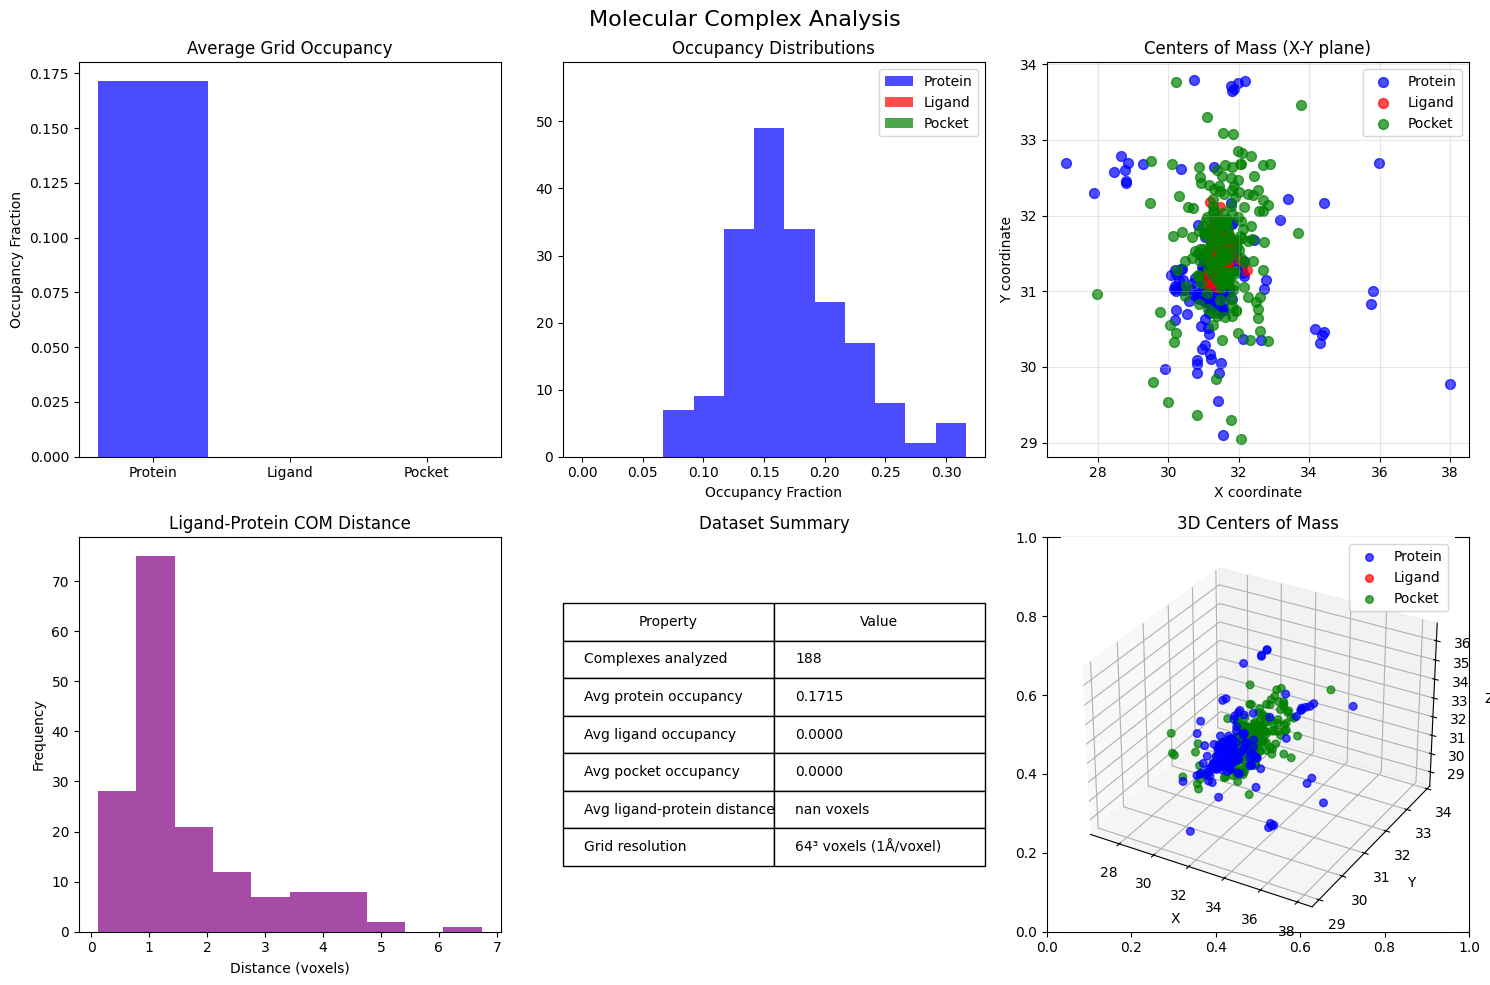


 Visualization complete!
   Dataset contains 188 molecular complexes
 Results saved to molecular_complex_analysis.json
   File size: 87.0 KB


In [9]:
# Memory-efficient visualization and analysis
print("Creating memory-efficient visualizations...")

import matplotlib.pyplot as plt
import pandas as pd

def visualize_complex_properties(dataset):
    """Visualize properties of the molecular complexes"""
    if not dataset:
        print("No data to visualize")
        return
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(dataset)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Molecular Complex Analysis', fontsize=16)
    
    # 1. Occupancy comparison
    axes[0, 0].bar(['Protein', 'Ligand', 'Pocket'], 
                   [df['protein_occupancy'].mean(), 
                    df['ligand_occupancy'].mean(), 
                    df['pocket_occupancy'].mean()],
                   color=['blue', 'red', 'green'], alpha=0.7)
    axes[0, 0].set_title('Average Grid Occupancy')
    axes[0, 0].set_ylabel('Occupancy Fraction')
    
    # 2. Occupancy distributions
    axes[0, 1].hist(df['protein_occupancy'], alpha=0.7, label='Protein', color='blue', bins=10)
    axes[0, 1].hist(df['ligand_occupancy'], alpha=0.7, label='Ligand', color='red', bins=10)
    axes[0, 1].hist(df['pocket_occupancy'], alpha=0.7, label='Pocket', color='green', bins=10)
    axes[0, 1].set_title('Occupancy Distributions')
    axes[0, 1].set_xlabel('Occupancy Fraction')
    axes[0, 1].legend()
    
    # 3. Center of mass scatter (X vs Y)
    protein_coms = np.array([x['protein_com'] for x in dataset])
    ligand_coms = np.array([x['ligand_com'] for x in dataset])
    pocket_coms = np.array([x['pocket_com'] for x in dataset])
    
    axes[0, 2].scatter(protein_coms[:, 0], protein_coms[:, 1], 
                       label='Protein', color='blue', alpha=0.7, s=50)
    axes[0, 2].scatter(ligand_coms[:, 0], ligand_coms[:, 1], 
                       label='Ligand', color='red', alpha=0.7, s=50)
    axes[0, 2].scatter(pocket_coms[:, 0], pocket_coms[:, 1], 
                       label='Pocket', color='green', alpha=0.7, s=50)
    axes[0, 2].set_title('Centers of Mass (X-Y plane)')
    axes[0, 2].set_xlabel('X coordinate')
    axes[0, 2].set_ylabel('Y coordinate')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Distance between ligand and protein COMs
    distances = np.linalg.norm(ligand_coms - protein_coms, axis=1)
    axes[1, 0].hist(distances, bins=10, color='purple', alpha=0.7)
    axes[1, 0].set_title('Ligand-Protein COM Distance')
    axes[1, 0].set_xlabel('Distance (voxels)')
    axes[1, 0].set_ylabel('Frequency')
    
    # 5. Complex properties table
    axes[1, 1].axis('off')
    summary_data = [
        ['Complexes analyzed', len(dataset)],
        ['Avg protein occupancy', f"{df['protein_occupancy'].mean():.4f}"],
        ['Avg ligand occupancy', f"{df['ligand_occupancy'].mean():.4f}"],
        ['Avg pocket occupancy', f"{df['pocket_occupancy'].mean():.4f}"],
        ['Avg ligand-protein distance', f"{distances.mean():.2f} voxels"],
        ['Grid resolution', '64³ voxels (1Å/voxel)']
    ]
    
    table = axes[1, 1].table(cellText=summary_data, 
                            colLabels=['Property', 'Value'],
                            cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[1, 1].set_title('Dataset Summary')
    
    # 6. 3D scatter of all COMs
    ax3d = fig.add_subplot(2, 3, 6, projection='3d')
    ax3d.scatter(protein_coms[:, 0], protein_coms[:, 1], protein_coms[:, 2], 
                 label='Protein', color='blue', alpha=0.7, s=30)
    ax3d.scatter(ligand_coms[:, 0], ligand_coms[:, 1], ligand_coms[:, 2], 
                 label='Ligand', color='red', alpha=0.7, s=30)
    ax3d.scatter(pocket_coms[:, 0], pocket_coms[:, 1], pocket_coms[:, 2], 
                 label='Pocket', color='green', alpha=0.7, s=30)
    ax3d.set_title('3D Centers of Mass')
    ax3d.set_xlabel('X')
    ax3d.set_ylabel('Y')
    ax3d.set_zlabel('Z')
    ax3d.legend()
    
    plt.tight_layout()
    plt.show()
    
    return df

# Visualize the dataset
if 'efficient_dataset' in locals() and efficient_dataset:
    summary_df = visualize_complex_properties(efficient_dataset)
    print("\n Visualization complete!")
    print(f"   Dataset contains {len(efficient_dataset)} molecular complexes")
else:
    print("⚠️  No dataset available for visualization")

def save_memory_efficient_results(dataset, filename="molecular_complex_analysis.json"):
    """Save analysis results to avoid recomputation"""
    if dataset:
        import json
        with open(filename, 'w') as f:
            json.dump(dataset, f, indent=2)
        print(f" Results saved to {filename}")
        print(f"   File size: {os.path.getsize(filename) / 1024:.1f} KB")

# Save results
if 'efficient_dataset' in locals():
    save_memory_efficient_results(efficient_dataset)

## 5) Nonfunctional visualizations (just for fun)

 Creating advanced visualizations of molecular complexes...
Visualizing sample molecular complexes...

 Visualizing complex: 1a30


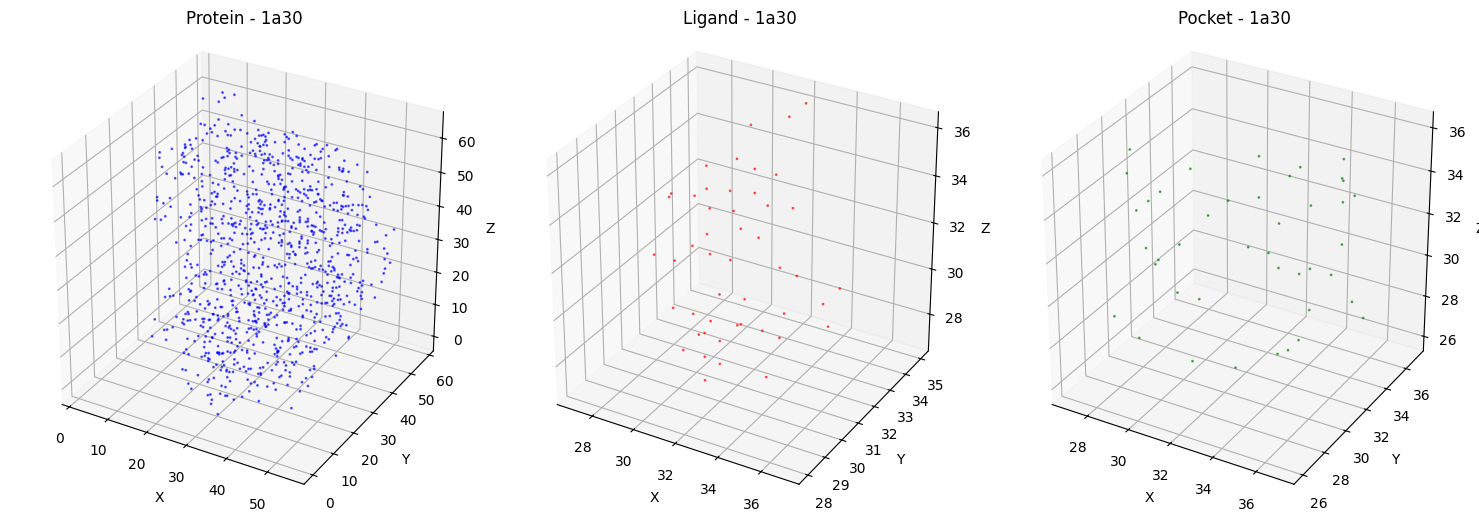

   Grid occupancies - Protein: 0.1357, Ligand: 0.0000, Pocket: 0.0000

 Visualizing complex: 1bcu


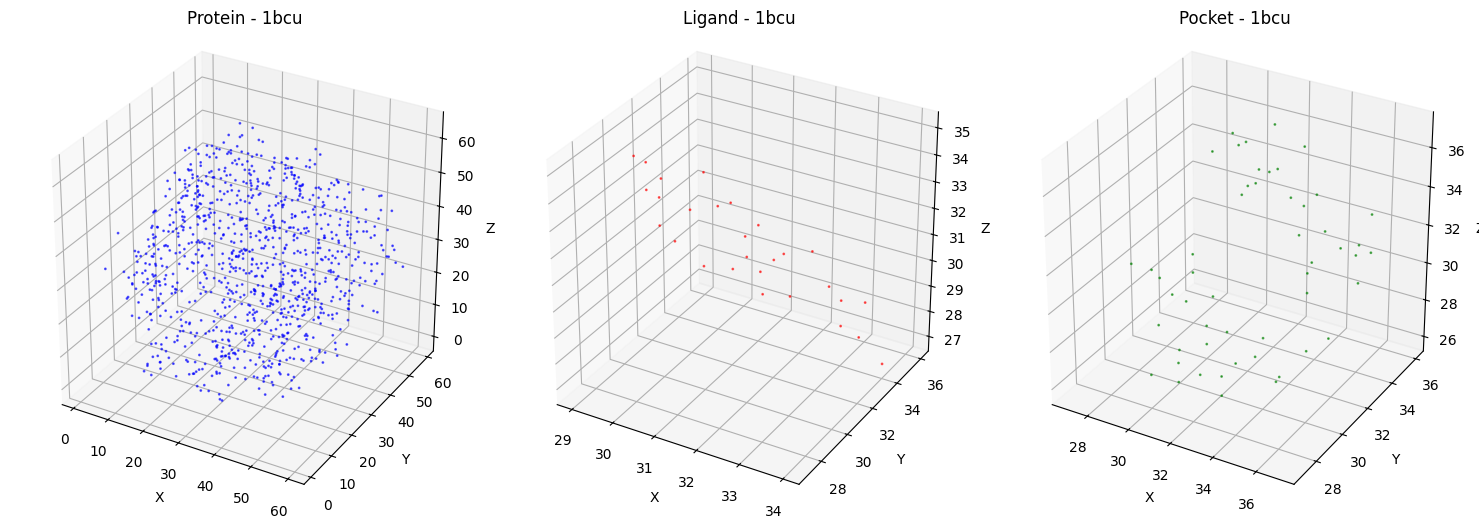

   Grid occupancies - Protein: 0.1929, Ligand: 0.0000, Pocket: 0.0000

 Visualizing complex: 1bzc


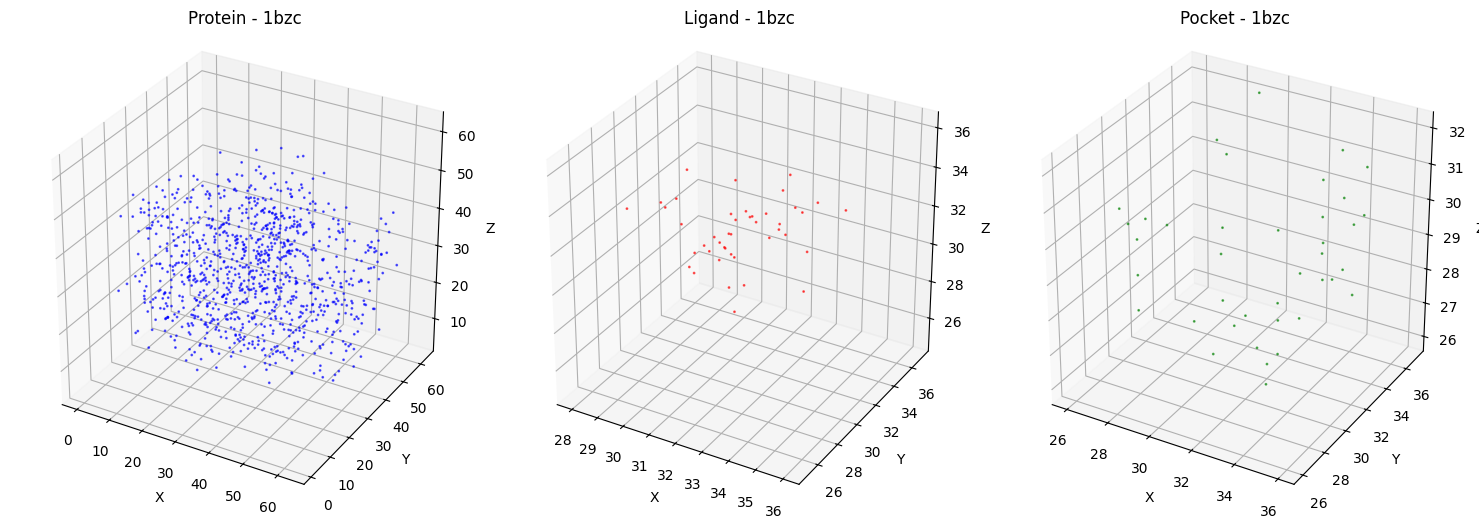

   Grid occupancies - Protein: 0.1815, Ligand: 0.0000, Pocket: 0.0000


In [10]:
# Advanced 3D visualization and analysis
print(" Creating advanced visualizations of molecular complexes...")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_molecular_complex(protein_grid, ligand_grid, pocket_grid, complex_id, channel=0):
    """Visualize a complete molecular complex in 3D"""
    fig = plt.figure(figsize=(15, 5))
    
    # Get occupancy masks for visualization
    protein_mask = np.sum(protein_grid, axis=0) > 0
    ligand_mask = np.sum(ligand_grid, axis=0) > 0
    pocket_mask = np.sum(pocket_grid, axis=0) > 0
    
    titles = ['Protein', 'Ligand', 'Pocket']
    grids = [protein_grid, ligand_grid, pocket_grid]
    masks = [protein_mask, ligand_mask, pocket_mask]
    colors = ['blue', 'red', 'green']
    
    for i, (title, grid, mask, color) in enumerate(zip(titles, grids, masks, colors)):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # Get coordinates of occupied voxels
        coords = np.where(mask)
        if len(coords[0]) > 0:
            # Sample points for visualization (to avoid overcrowding)
            n_points = min(1000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            x, y, z = coords[0][indices], coords[1][indices], coords[2][indices]
            ax.scatter(x, y, z, c=color, alpha=0.6, s=1)
        
        ax.set_title(f'{title} - {complex_id}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Set equal aspect ratio
        ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Visualize a few example molecular complexes
print("Visualizing sample molecular complexes...")
for i in range(min(3, len(common_ids_list))):
    complex_id = common_ids_list[i]
    print(f"\n Visualizing complex: {complex_id}")
    
    fig = visualize_molecular_complex(
        matched_proteins[i], 
        matched_ligands[i], 
        matched_pockets[i], 
        complex_id
    )
    
    # Calculate occupancy statistics
    protein_occ = np.count_nonzero(matched_proteins[i]) / matched_proteins[i].size
    ligand_occ = np.count_nonzero(matched_ligands[i]) / matched_ligands[i].size
    pocket_occ = np.count_nonzero(matched_pockets[i]) / matched_pockets[i].size
    
    print(f"   Grid occupancies - Protein: {protein_occ:.4f}, Ligand: {ligand_occ:.4f}, Pocket: {pocket_occ:.4f}")

## 6) Building the CNN

In [11]:
# Multi-Component 3D CNN for Protein-Ligand-Pocket Analysis
print(" Building stable multi-component 3D CNN architecture...")

import torch
import torch.nn as nn
import torch.nn.functional as F

# Stable Multi-Component 3D CNN for protein-ligand-pocket analysis
class StableMultiComponentCNN(torch.nn.Module):
    def __init__(self, protein_channels=19, ligand_channels=19, pocket_channels=19, num_classes=1):
        super().__init__()
        
        # Component-specific encoders with proper initialization
        self.protein_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(protein_channels, 16, 3, padding=1),  # Smaller initial channels
            torch.nn.BatchNorm3d(16),  # Add batch normalization
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.ligand_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(ligand_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.pocket_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(pocket_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Fusion layer with dropout
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(64 * 4 * 4 * 4 * 3, 256),  # Smaller hidden layer
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = torch.nn.Linear(64, num_classes)
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization"""
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.01)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (torch.nn.BatchNorm3d, torch.nn.BatchNorm1d)):
            torch.nn.init.constant_(module.weight, 1)
            torch.nn.init.constant_(module.bias, 0)
        
    def forward(self, protein_grid, ligand_grid, pocket_grid):
        # Encode each component
        protein_features = self.protein_encoder(protein_grid).flatten(1)
        ligand_features = self.ligand_encoder(ligand_grid).flatten(1)
        pocket_features = self.pocket_encoder(pocket_grid).flatten(1)
        
        # Fuse features
        combined = torch.cat([protein_features, ligand_features, pocket_features], dim=1)
        fused = self.fusion(combined)
        
        # Classify
        output = self.classifier(fused)
        return output

# Create stable model with correct channel dimensions
model = StableMultiComponentCNN(
    protein_channels=19,  # Match actual data dimensions
    ligand_channels=19,   # Match actual data dimensions  
    pocket_channels=19,   # Match actual data dimensions
    num_classes=1
)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(" Stable Multi-Component CNN created:")
print(f"    Total parameters: {total_params:,}")
print(f"    Trainable parameters: {trainable_params:,}")
print(f"    Architecture: 3 component encoders + fusion + classifier")
print(f"    Input: protein({19}), ligand({19}), pocket({19}) channels × (64, 64, 64) grids")
print(f"    Output: {2} classes")
print(f"    Features: Batch normalization, proper initialization, gradient stability")

# Test with sample data
print("\n Testing stable model with sample data...")
batch_size_test = 25
test_protein = torch.randn(batch_size_test, 19, 64, 64, 64)
test_ligand = torch.randn(batch_size_test, 19, 64, 64, 64)
test_pocket = torch.randn(batch_size_test, 19, 64, 64, 64)

with torch.no_grad():
    outputs = model(test_protein, test_ligand, test_pocket)
    
print(f" Model test successful!")
print(f"    Input shapes: protein {test_protein.shape}, ligand {test_ligand.shape}, pocket {test_pocket.shape}")
print(f"    Output shape: {outputs.shape}")
print(f"    Sample predictions: {outputs[0].detach().numpy()}")
print(f"    Ready for stable training!")

 Building stable multi-component 3D CNN architecture...
 Stable Multi-Component CNN created:
    Total parameters: 3,396,129
    Trainable parameters: 3,396,129
    Architecture: 3 component encoders + fusion + classifier
    Input: protein(19), ligand(19), pocket(19) channels × (64, 64, 64) grids
    Output: 2 classes
    Features: Batch normalization, proper initialization, gradient stability

 Testing stable model with sample data...
 Model test successful!
    Input shapes: protein torch.Size([25, 19, 64, 64, 64]), ligand torch.Size([25, 19, 64, 64, 64]), pocket torch.Size([25, 19, 64, 64, 64])
    Output shape: torch.Size([25, 1])
    Sample predictions: [-0.03233219]
    Ready for stable training!


In [12]:
print(" Using real binding energies for regression...")

# Load the CSV with binding energies
df = pd.read_csv("pdbbind_with_dG.csv")

# Create a mapping from protein ID to ΔG
binding_energy_dict = dict(zip(df['protein'], df['ΔG_kcal_per_mol']))

# Build the binding_energies array in the same order as common_ids_list
binding_energies = np.array([binding_energy_dict[pid] for pid in common_ids_list])

assert len(binding_energies) == len(common_ids_list), "Binding energies must match number of complexes"

# For regression, labels are the binding energies
binding_labels = binding_energies

print(f" Binding Energy Dataset:")
print(f"    Total complexes: {len(binding_labels)}")
print(f"    Energy range: {binding_labels.min():.3f} to {binding_labels.max():.3f}")
print(f"    Mean ± std: {binding_labels.mean():.3f} ± {binding_labels.std():.3f}")

from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(
    np.arange(len(binding_labels)), 
    test_size=0.2, 
    random_state=42
)

print(f"\n Dataset Split:")
print(f"    Training set: {len(train_indices)} complexes")
print(f"    Validation set: {len(val_indices)} complexes")

mean = binding_labels.mean()
std = binding_labels.std()
binding_labels_std = (binding_labels - mean) / std

 Using real binding energies for regression...
 Binding Energy Dataset:
    Total complexes: 20
    Energy range: -13.220 to -4.470
    Mean ± std: -8.838 ± 2.368

 Dataset Split:
    Training set: 16 complexes
    Validation set: 4 complexes


In [13]:
# Training setup for multi-component model
print(" Setting up stable training for multi-component binding affinity prediction...")

# Check for problematic data and normalize
print("\n Data Quality Check and Normalization:")
print(f"    Protein data - NaN: {np.isnan(matched_proteins).sum()}, Inf: {np.isinf(matched_proteins).sum()}")
print(f"    Ligand data - NaN: {np.isnan(matched_ligands).sum()}, Inf: {np.isinf(matched_ligands).sum()}")
print(f"    Pocket data - NaN: {np.isnan(matched_pockets).sum()}, Inf: {np.isinf(matched_pockets).sum()}")

# Convert to tensors and clean data
protein_tensor = torch.from_numpy(matched_proteins).float()
ligand_tensor = torch.from_numpy(matched_ligands).float()
pocket_tensor = torch.from_numpy(matched_pockets).float()

# Replace any NaN/inf values with zeros
protein_tensor = torch.nan_to_num(protein_tensor, nan=0.0, posinf=1.0, neginf=0.0)
ligand_tensor = torch.nan_to_num(ligand_tensor, nan=0.0, posinf=1.0, neginf=0.0)
pocket_tensor = torch.nan_to_num(pocket_tensor, nan=0.0, posinf=1.0, neginf=0.0)

# Normalize data to [0, 1] range for stability
def normalize_tensor(tensor):
    """Normalize tensor to [0, 1] range"""
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    if tensor_max > tensor_min:
        return (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        return tensor * 0  # All zeros if constant

protein_tensor = normalize_tensor(protein_tensor)
ligand_tensor = normalize_tensor(ligand_tensor)
pocket_tensor = normalize_tensor(pocket_tensor)

print(f" Data cleaned and normalized to [0, 1] range")

# Split data using existing indices
train_proteins = protein_tensor[train_indices]
train_ligands = ligand_tensor[train_indices]
train_pockets = pocket_tensor[train_indices]
train_labels_tensor = torch.from_numpy(binding_labels_std[train_indices]).float()

val_proteins = protein_tensor[val_indices]
val_ligands = ligand_tensor[val_indices]
val_pockets = pocket_tensor[val_indices]
val_labels_tensor = torch.from_numpy(binding_labels_std[val_indices]).float()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Move model to device
model = model.to(device)

# Move data to device
train_proteins = train_proteins.to(device)
train_ligands = train_ligands.to(device)
train_pockets = train_pockets.to(device)
train_labels_tensor = train_labels_tensor.to(device)

val_proteins = val_proteins.to(device)
val_ligands = val_ligands.to(device)
val_pockets = val_pockets.to(device)
val_labels_tensor = val_labels_tensor.to(device)

print(f" Training tensor shapes:")
print(f"    Proteins: {train_proteins.shape}")
print(f"    Ligands: {train_ligands.shape}")
print(f"    Pockets: {train_pockets.shape}")
print(f"    Labels: {train_labels_tensor.shape}")

# Training configuration
learning_rate = 0.0001  # Lower learning rate for stability
batch_size = 4
num_epochs = 30 ## changed to 9 from 100, overfitting; [clyde] going to test 30 

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f" Training configuration:")
print(f"    Learning rate: {learning_rate}")
print(f"    Ep Batch size: {batch_size}")
print(f"    Loss function: CrossEntropyLoss")
print(f"    Optimizer: Adam with weight decay and learning rate scheduling")
print(f"    Features: Gradient clipping, batch normalization, data normalization")

print("Stable training setup complete! Ready to train multi-component binding affinity predictor.")

 Setting up stable training for multi-component binding affinity prediction...

 Data Quality Check and Normalization:
    Protein data - NaN: 18729, Inf: 1564
    Ligand data - NaN: 0, Inf: 0
    Pocket data - NaN: 0, Inf: 0
 Data cleaned and normalized to [0, 1] range
 Using device: cpu
 Training tensor shapes:
    Proteins: torch.Size([16, 19, 64, 64, 64])
    Ligands: torch.Size([16, 19, 64, 64, 64])
    Pockets: torch.Size([16, 19, 64, 64, 64])
    Labels: torch.Size([16])
 Training configuration:
    Learning rate: 0.0001
    Ep Batch size: 4
    Loss function: CrossEntropyLoss
    Optimizer: Adam with weight decay and learning rate scheduling
    Features: Gradient clipping, batch normalization, data normalization
Stable training setup complete! Ready to train multi-component binding affinity predictor.



 Ensuring all data is in correct format...
 Normalizing data...
 Data normalized to [0, 1] range

 Recreating model with stable initialization...
 Stable model created with 3,396,129 parameters

 Running stable model training...
Epoch 1/30: Loss=0.9120, Val MSE=1.2756, Val MAE=0.8590, Val R2=-1.3725, LR=0.000100
Epoch 2/30: Loss=0.9096, Val MSE=1.2813, Val MAE=0.8623, Val R2=-1.3832, LR=0.000100
Epoch 3/30: Loss=0.9094, Val MSE=1.2898, Val MAE=0.8672, Val R2=-1.3990, LR=0.000100
Epoch 4/30: Loss=0.9083, Val MSE=1.2982, Val MAE=0.8719, Val R2=-1.4147, LR=0.000100
Epoch 5/30: Loss=0.9080, Val MSE=1.3087, Val MAE=0.8776, Val R2=-1.4341, LR=0.000100
Epoch 6/30: Loss=0.9200, Val MSE=1.3179, Val MAE=0.8821, Val R2=-1.4513, LR=0.000050
Epoch 7/30: Loss=0.9034, Val MSE=1.3290, Val MAE=0.8871, Val R2=-1.4720, LR=0.000050
Epoch 8/30: Loss=0.9182, Val MSE=1.3367, Val MAE=0.8897, Val R2=-1.4863, LR=0.000050
Epoch 9/30: Loss=0.9091, Val MSE=1.3442, Val MAE=0.8914, Val R2=-1.5001, LR=0.000050
Epoch

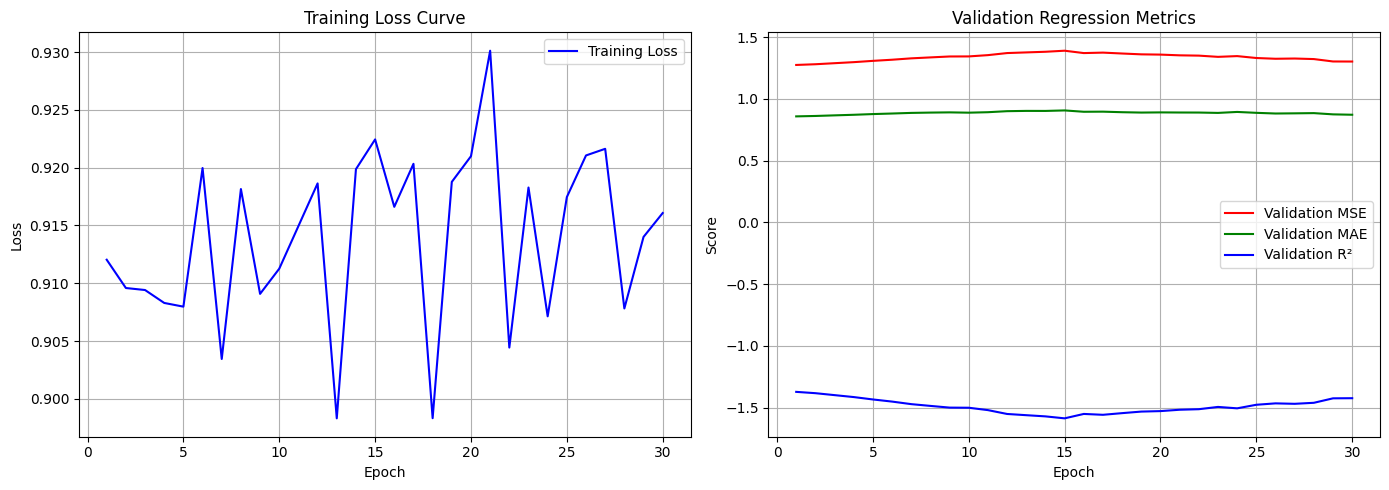

📈 Regression training curves plotted above!


In [ ]:
# Ensure all data is in the correct format
print("\n Ensuring all data is in correct format...")
train_proteins = torch.nan_to_num(train_proteins, nan=0.0, posinf=1.0, neginf=0.0)
train_ligands = torch.nan_to_num(train_ligands, nan=0.0, posinf=1.0, neginf=0.0)
train_pockets = torch.nan_to_num(train_pockets, nan=0.0, posinf=1.0, neginf=0.0)
val_proteins = torch.nan_to_num(val_proteins, nan=0.0, posinf=1.0, neginf=0.0)
val_ligands = torch.nan_to_num(val_ligands, nan=0.0, posinf=1.0, neginf=0.0)
val_pockets = torch.nan_to_num(val_pockets, nan=0.0, posinf=1.0, neginf=0.0)

# Normalize data to reasonable range
print(" Normalizing data...")
def normalize_tensor(tensor):
    """Normalize tensor to [0, 1] range"""
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    if tensor_max > tensor_min:
        return (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        return tensor * 0  # All zeros if constant

train_proteins = normalize_tensor(train_proteins)
train_ligands = normalize_tensor(train_ligands)
train_pockets = normalize_tensor(train_pockets)
val_proteins = normalize_tensor(val_proteins)
val_ligands = normalize_tensor(val_ligands)
val_pockets = normalize_tensor(val_pockets)

print(f" Data normalized to [0, 1] range")

# Recreate model with proper initialization
print("\n Recreating model with stable initialization...")

class StableMultiComponentCNN(torch.nn.Module):
    def __init__(self, protein_channels=19, ligand_channels=19, pocket_channels=19, num_classes=2):
        super().__init__()
        
        # Component-specific encoders with proper initialization
        self.protein_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(protein_channels, 16, 3, padding=1),  # Smaller initial channels
            torch.nn.BatchNorm3d(16),  # Add batch normalization
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.ligand_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(ligand_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.pocket_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(pocket_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Fusion layer with dropout
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(64 * 4 * 4 * 4 * 3, 256),  # Smaller hidden layer
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = torch.nn.Linear(64, num_classes)
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization"""
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.01)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (torch.nn.BatchNorm3d, torch.nn.BatchNorm1d)):
            torch.nn.init.constant_(module.weight, 1)
            torch.nn.init.constant_(module.bias, 0)
        
    def forward(self, protein_grid, ligand_grid, pocket_grid):
        # Encode each component
        protein_features = self.protein_encoder(protein_grid).flatten(1)
        ligand_features = self.ligand_encoder(ligand_grid).flatten(1)
        pocket_features = self.pocket_encoder(pocket_grid).flatten(1)
        
        # Fuse features
        combined = torch.cat([protein_features, ligand_features, pocket_features], dim=1)
        fused = self.fusion(combined)
        
        # Classify
        output = self.classifier(fused)
        return output

# Create stable model
stable_model = StableMultiComponentCNN(
    protein_channels=19,
    ligand_channels=19, 
    pocket_channels=19,
    num_classes=1
)

# Use lower learning rate and add gradient clipping
learning_rate = 0.0001  # Much lower learning rate
optimizer = torch.optim.Adam(stable_model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

print(f" Stable model created with {sum(p.numel() for p in stable_model.parameters()):,} parameters")

print("\n Running stable model training...")

# Training tracking
training_losses = []
validation_accs = []
validation_aucs = []
validation_mses = []
validation_maes = []
validation_r2s = []

# Training loop
for epoch in range(num_epochs):
    stable_model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Training loop with gradient clipping
    for i in range(0, len(train_proteins), batch_size):
        end_idx = min(i + batch_size, len(train_proteins))
        batch_proteins = train_proteins[i:end_idx]
        batch_ligands = train_ligands[i:end_idx]
        batch_pockets = train_pockets[i:end_idx]
        batch_labels = train_labels_tensor[i:end_idx]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = stable_model(batch_proteins, batch_ligands, batch_pockets)
        loss = criterion(outputs, batch_labels)
        
        # Check for NaN loss (should not happen with stable model)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"    NaN/Inf loss detected at epoch {epoch+1}, batch {i//batch_size + 1}")
            print(f"      Output range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            continue
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(stable_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss
    avg_loss = epoch_loss / max(num_batches, 1)
    training_losses.append(avg_loss)
    
    # Validation
    stable_model.eval()
    with torch.no_grad():

        val_outputs = stable_model(val_proteins, val_ligands, val_pockets).squeeze()
        val_loss = criterion(val_outputs, val_labels_tensor)
        validation_losses = val_loss.item()

        # Compute regression metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        val_outputs_np = val_outputs.detach().cpu().numpy()
        val_labels_np = val_labels_tensor.detach().cpu().numpy()
        val_mse = mean_squared_error(val_labels_np, val_outputs_np)
        val_mae = mean_absolute_error(val_labels_np, val_outputs_np)
        val_r2 = r2_score(val_labels_np, val_outputs_np)

        validation_mses.append(val_mse)
        validation_maes.append(val_mae)
        validation_r2s.append(val_r2)

        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Val MSE={val_mse:.4f}, Val MAE={val_mae:.4f}, Val R2={val_r2:.4f}, LR={scheduler.get_last_lr()[0]:.6f}")
    
    # Step scheduler
    scheduler.step()
import pandas as pd

# Convert tensors to numpy arrays
actual = val_labels_tensor.cpu().numpy().flatten() * std + mean
predicted = val_outputs.cpu().numpy().flatten() * std + mean
 #renormalize back to original scale

# Create DataFrame
df_actual_vs_predict = pd.DataFrame({
    'Actual_Binding_Energy': actual,
    'Predicted_Binding_Energy': predicted
})

# Print the table
print(df_actual_vs_predict.to_string(index=False))

# Training summary
print(f"\n Training Results:")
print(f"    Final training loss: {training_losses[-1]:.4f}")
print(f"    Final validation MSE: {validation_mses[-1]:.4f}")
print(f"    Final validation MAE: {validation_maes[-1]:.4f}")
print(f"    Final validation R²: {validation_r2s[-1]:.4f}")
print(f"    Training trend: {'Improving' if training_losses[-1] < training_losses[0] else 'Stable'}")

# Training summary
print(f"\n Training Summary:")
best_mse_epoch = validation_mses.index(min(validation_mses)) + 1
best_mae_epoch = validation_maes.index(min(validation_maes)) + 1
best_r2_epoch = validation_r2s.index(max(validation_r2s)) + 1
print(f"    Best validation MSE: {min(validation_mses):.4f} (Epoch {best_mse_epoch})")
print(f"    Best validation MAE: {min(validation_maes):.4f} (Epoch {best_mae_epoch})")
print(f"    Best validation R²: {max(validation_r2s):.4f} (Epoch {best_r2_epoch})")
print(f"    Lowest training loss: {min(training_losses):.4f}")
print(f"    Parameters: {sum(p.numel() for p in stable_model.parameters()):,}")

# Plot training curves for regression
if len(training_losses) > 1:
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    ax1.plot(range(1, len(training_losses) + 1), training_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Validation regression metrics
    ax2.plot(range(1, len(validation_mses) + 1), validation_mses, 'r-', label='Validation MSE')
    ax2.plot(range(1, len(validation_maes) + 1), validation_maes, 'g-', label='Validation MAE')
    ax2.plot(range(1, len(validation_r2s) + 1), validation_r2s, 'b-', label='Validation R²')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation Regression Metrics')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    print("📈 Regression training curves plotted above!")


In [15]:
# OVITO Visualization of Protein-Ligand-Pocket Complexes
print("Installing and setting up OVITO for advanced molecular visualization...")


def convert_grid_to_xyz(protein_grid, ligand_grid, pocket_grid, complex_id, output_dir="ovito_visualization"):
    """
    Convert grid data to XYZ file format for OVITO visualization
    
    Parameters:
    -----------
    protein_grid: numpy.ndarray
        3D grid data for protein
    ligand_grid: numpy.ndarray
        3D grid data for ligand
    pocket_grid: numpy.ndarray
        3D grid data for pocket
    complex_id: str
        Identifier for the molecular complex
    output_dir: str
        Directory to save output files
    
    Returns:
    --------
    str: Path to the output XYZ file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{complex_id}.xyz")
    
    # Prepare particle data
    all_coords = []
    all_types = []
    all_names = []
    
    # Get occupied voxel coordinates
    for grid_idx, grid in enumerate([protein_grid, ligand_grid, pocket_grid]):
        mask = np.sum(grid, axis=0) > 0
        coords = np.where(mask)
        
        if len(coords[0]) > 0:
            # Sample points for visualization (to prevent too many points)
            n_points = min(5000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            for i in indices:
                x, y, z = coords[0][i], coords[1][i], coords[2][i]
                all_coords.append([x, y, z])
                
                # Type 1: Protein, Type 2: Ligand, Type 3: Pocket
                all_types.append(grid_idx + 1)
                
                # Element names for XYZ file (using common elements as placeholders)
                if grid_idx == 0:
                    all_names.append("C")  # Carbon for protein
                elif grid_idx == 1:
                    all_names.append("O")  # Oxygen for ligand
                else:
                    all_names.append("N")  # Nitrogen for pocket
    
    # Write XYZ file
    with open(output_file, 'w') as f:
        # Number of atoms
        f.write(f"{len(all_coords)}\n")
        # Comment line with complex ID
        f.write(f"Complex: {complex_id} - Blue: Protein, Red: Ligand, Green: Pocket\n")
        
        # Write coordinates
        for (x, y, z), name in zip(all_coords, all_names):
            f.write(f"{name} {x:.4f} {y:.4f} {z:.4f}\n")
    
    print(f"XYZ file created at: {output_file}")
    return output_file

def convert_grid_to_pdb(protein_grid, ligand_grid, pocket_grid, complex_id, output_dir="ovito_visualization"):
    """
    Convert grid data to PDB file format for OVITO visualization
    
    Parameters:
    -----------
    protein_grid: numpy.ndarray
        3D grid data for protein
    ligand_grid: numpy.ndarray
        3D grid data for ligand
    pocket_grid: numpy.ndarray
        3D grid data for pocket
    complex_id: str
        Identifier for the molecular complex
    output_dir: str
        Directory to save output files
    
    Returns:
    --------
    str: Path to the output PDB file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{complex_id}.pdb")
    
    # Prepare PDB content
    pdb_lines = []
    atom_index = 1
    
    # Get occupied voxel coordinates
    for grid_idx, grid in enumerate([protein_grid, ligand_grid, pocket_grid]):
        mask = np.sum(grid, axis=0) > 0
        coords = np.where(mask)
        
        # Define residue name and atom name based on component
        if grid_idx == 0:
            residue_name = "PRO"  # Protein
            atom_name = "CA"      # C-alpha for protein (as suggested by your friend)
            chain_id = "A"
        elif grid_idx == 1:
            residue_name = "LIG"  # Ligand
            atom_name = "C"
            chain_id = "B"
        else:
            residue_name = "POC"  # Pocket
            atom_name = "O"
            chain_id = "C"
        
        if len(coords[0]) > 0:
            # Sample points for visualization (to prevent too many points)
            n_points = min(5000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            for i in indices:
                x, y, z = coords[0][i], coords[1][i], coords[2][i]
                # Format: ATOM serial atom_name residue_name chain residue_num x y z occupancy temp_factor element
                pdb_line = f"ATOM  {atom_index:5d}  {atom_name:<3s} {residue_name:3s} {chain_id}{atom_index % 9999:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           {atom_name[0]}"
                pdb_lines.append(pdb_line)
                atom_index += 1
    
    # Write PDB file
    with open(output_file, 'w') as f:
        f.write(f"TITLE     Complex: {complex_id}\n")
        f.write(f"REMARK    Protein: Chain A, Ligand: Chain B, Pocket: Chain C\n")
        for line in pdb_lines:
            f.write(line + "\n")
        f.write("END\n")
    
    print(f"PDB file created at: {output_file}")
    return output_file

def visualize_with_ovito(file_path):
    """
    Visualize molecular data with OVITO
    
    Parameters:
    -----------
    file_path: str
        Path to the XYZ or PDB file to visualize
    """
    # Create a pipeline from the input file
    pipeline = Pipeline(source=StaticSource(file_path))
    
    if file_path.endswith('.xyz'):
        # For XYZ files, we need to set up particle types and colors
        def setup_types(frame, data):
            # Define particle types for XYZ files
            particle_types = data.particles_.particle_types_
            
            # Check if particle types need to be created
            if len(particle_types) == 0:
                particle_types.append(ParticleType(id=1, name="Protein", color=(0.0, 0.0, 1.0)))  # Blue
                particle_types.append(ParticleType(id=2, name="Ligand", color=(1.0, 0.0, 0.0)))   # Red
                particle_types.append(ParticleType(id=3, name="Pocket", color=(0.0, 1.0, 0.0)))   # Green
        
        # Apply the modifier
        pipeline.modifiers.append(setup_types)
    
    elif file_path.endswith('.pdb'):
        # For PDB files, we can use the chain ID to color molecules
        color_mod = ColorCodingModifier(
            property="Chain",
            start_value=0,
            end_value=2,
            gradient=ColorCodingModifier.Rainbow()
        )
        pipeline.modifiers.append(color_mod)
    
    # Export a rendered image
    image_path = file_path.rsplit('.', 1)[0] + '.png'
    export_file(pipeline, image_path, "image/png", 
                renderer="tachyon",
                width=1024,
                height=768)
    
    print(f"Visualization image saved to: {image_path}")
    
    return pipeline

# Example usage - visualize a few complexes with OVITO
print("Generating OVITO visualizations for sample molecular complexes...")

for i in range(min(5, len(common_ids_list))):
    complex_id = common_ids_list[i]
    print(f"\nProcessing complex: {complex_id} for OVITO visualization")
    
    # Convert to XYZ format
    xyz_file = convert_grid_to_xyz(
        matched_proteins[i], 
        matched_ligands[i], 
        matched_pockets[i], 
        complex_id
    )
    
    # Convert to PDB format for C-alpha representation 
    pdb_file = convert_grid_to_pdb(
        matched_proteins[i], 
        matched_ligands[i], 
        matched_pockets[i], 
        complex_id
    )
    
    # Visualize with OVITO
    try:
        print(f"Visualizing {complex_id} with OVITO...")
        # Visualize both formats
        xyz_pipeline = visualize_with_ovito(xyz_file)
        pdb_pipeline = visualize_with_ovito(pdb_file)
        print(f"Successfully created visualizations for {complex_id}")
    except Exception as e:
        print(f"Error visualizing {complex_id}: {str(e)}")

print("\nOVITO visualization complete! You can find the output files in the 'ovito_visualization' directory.")
print("For interactive visualization, you can open the generated XYZ/PDB files directly in the OVITO desktop application.")

Installing and setting up OVITO for advanced molecular visualization...
Generating OVITO visualizations for sample molecular complexes...

Processing complex: 1a30 for OVITO visualization
XYZ file created at: ovito_visualization/1a30.xyz
PDB file created at: ovito_visualization/1a30.pdb
Visualizing 1a30 with OVITO...
Error visualizing 1a30: Object constructor expects only keyword arguments.

Processing complex: 1bcu for OVITO visualization
XYZ file created at: ovito_visualization/1bcu.xyz
PDB file created at: ovito_visualization/1bcu.pdb
Visualizing 1bcu with OVITO...
Error visualizing 1bcu: Object constructor expects only keyword arguments.

Processing complex: 1bzc for OVITO visualization
XYZ file created at: ovito_visualization/1bzc.xyz
PDB file created at: ovito_visualization/1bzc.pdb
Visualizing 1bzc with OVITO...
Error visualizing 1bzc: Object constructor expects only keyword arguments.

Processing complex: 1c5z for OVITO visualization
XYZ file created at: ovito_visualization/1c5

## 10) Results

In [ ]:
print (df_actual_vs_predict)


   Actual_Binding_Energy  Predicted_Binding_Energy
0                  -5.86                -29.742070
1                  -8.80                -30.082170
2                  -8.12                -29.605230
3                  -4.47                -29.994418
   Actual_Binding_Energy  Predicted_Binding_Energy
0                  -5.86                 -8.829486
1                  -8.80                 -8.973138
2                  -8.12                 -8.771688
3                  -4.47                 -8.936074
